In [1]:
import argparse
import json
import logging
import os
import random
import time
import os
import torch
import numpy as np

In [2]:
import sys 
sys.path.append('..')
import utils.misc as ws
import utils.data_utils
import utils.train_utils
import utils.eval_utils
import utils.mesh
import utils.dataset as d
import models.networks as arch


In [25]:
DATA_SOURCE = '/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/'
EXPERIMENTS_DIR = '../experiments/epochs_2000_weight_0.5/'
# EXPERIMENTS_DIR = '../experiments/epochs_3000_weight_0.8/'
CHECKPOINT = 'latest'
specs_filename = os.path.join(EXPERIMENTS_DIR, "specs.json")

# split_filename = '../split_train.json'
split_filename = '../split_validation.json'

reconstructions_subdir = ws.reconstructions_subdir
reconstruction_codes_subdir = ws.reconstruction_codes_subdir

def get_reconstructed_code_filename(experiment_dir, epoch, dataset, gripper_name, instance_name):    
    return os.path.join(
        experiment_dir,
        reconstructions_subdir,
        str(epoch),
        reconstruction_codes_subdir,
        dataset + '-sdf-' + gripper_name + '-' +instance_name + ".pth")


In [33]:
specs = json.load(open(specs_filename))

latent_size = specs["CodeLength"]

gripper_weight = specs["GripperWeight"]


dataset = '003_cracker_box_google_16k_textured_scale_1000'

gripper_name = 'fetch_gripper'



In [34]:
decoder = arch.dsdfDecoder(latent_size, **specs["NetworkSpecs"])

decoder = torch.nn.DataParallel(decoder)

saved_model_state = torch.load(
    os.path.join(
        EXPERIMENTS_DIR, ws.model_params_subdir, CHECKPOINT + ".pth")
)

saved_model_epoch = saved_model_state["epoch"]

decoder.load_state_dict(saved_model_state["model_state_dict"])

decoder = decoder.module.cuda()

In [36]:
with open(split_filename, "r") as f:
    split = json.load(f)

# npz_filenames = utils.data_utils.dsdf_get_instance_filenames(
#     args.data_source, split)
npz_filenames = utils.data_utils.get_instance_filelist(DATA_SOURCE, split)

npz_instances = utils.data_utils.get_instance_namelist(DATA_SOURCE, split)
# random.shuffle(npz_filenames) # WHY??? DISABLE THIS FOR CHECKING REPRODUCIBILITY

In [37]:
for f in npz_filenames:
    print(f[-15:])

graspnum_40.npz
graspnum_41.npz
graspnum_42.npz
graspnum_43.npz
graspnum_44.npz


In [13]:
# latent_vecs = ws.load_latent_vectors(EXPERIMENTS_DIR, CHECKPOINT)
# print(latent_vecs.shape)

torch.Size([40, 256])


In [38]:
index_to_select = random.randint(0, len(npz_filenames)-1)

npz = npz_filenames[index_to_select]

full_filename = npz

print(index_to_select, npz[-15:])
print(npz_instances[index_to_select])

npz_instance_name = npz_instances[index_to_select][:-4]
print(npz_instance_name)

1 graspnum_41.npz
sdf_graspnum_41.npz
sdf_graspnum_41


In [39]:
latent_vec_file = get_reconstructed_code_filename(EXPERIMENTS_DIR, 2000, dataset, gripper_name, npz_instance_name)
print(latent_vec_file)

../experiments/epochs_2000_weight_0.5/Reconstructions/2000/Codes/003_cracker_box_google_16k_textured_scale_1000-sdf-fetch_gripper-sdf_graspnum_41.pth


In [40]:
latent_vec = torch.load(latent_vec_file)
print(latent_vec.shape)
latent_vec = latent_vec.squeeze()
print(latent_vec.shape)

torch.Size([1, 1, 256])
torch.Size([256])


In [13]:
# ####### MESH RECONSTRUCTION CODE!

# is_gripper = True

# if is_gripper:
#     mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_{npz[-15:]}')
# else:
#     mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_o_{npz[-15:]}')


# latent_vec = latent_vec.squeeze().cuda()
# with torch.no_grad():
#     utils.mesh.create_mesh_custom(
#         decoder, latent_vec, mesh_filename, N=256, max_batch=int(2 ** 18), isGripper=is_gripper)


sampling takes: 11.106714


In [41]:
# IMPORTANT: HAVE SHUFFLE = FALSE SO THAT SAME DATA POINT IS LOADED AS index_to_select

sdf_dataset = d.SDFSamples(DATA_SOURCE, split, 1000000)

sdf_loader = torch.utils.data.DataLoader(
    sdf_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    drop_last=True)

In [42]:
# samples, npzfile = next(iter(sdf_loader))
samples, idx, npzfile = sdf_dataset[index_to_select]
print(npzfile[-40:])

queries = samples[:, :3] # Need to pass this through the network
gt_sdf_obj = samples[:, 3].squeeze().numpy()
gt_sdf_grp = samples[:, 4].squeeze().numpy()
print(gt_sdf_grp.shape)

00/sdf/fetch_gripper/sdf_graspnum_41.npz
(1000000,)


In [43]:
print(samples.shape)

torch.Size([1000000, 5])


In [44]:
with torch.no_grad():
    queries, sdf_obj, sdf_grp = utils.eval_utils.eval_query_pc(decoder, latent_vec.cuda(), queries)

In [45]:
queries = queries.detach().cpu().numpy()
sdf_obj = sdf_obj.detach().cpu().numpy()
sdf_grp = sdf_grp.detach().cpu().numpy()

In [46]:
print(sdf_grp.shape)
print(sdf_obj.shape)
print(queries.shape)

(1000000,)
(1000000,)
(1000000, 3)


In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot_sdf(xyz, sdf, title='Sample_Title', n_display=10000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.95, 0.95)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)
    plt.title(title)
    plt.show()

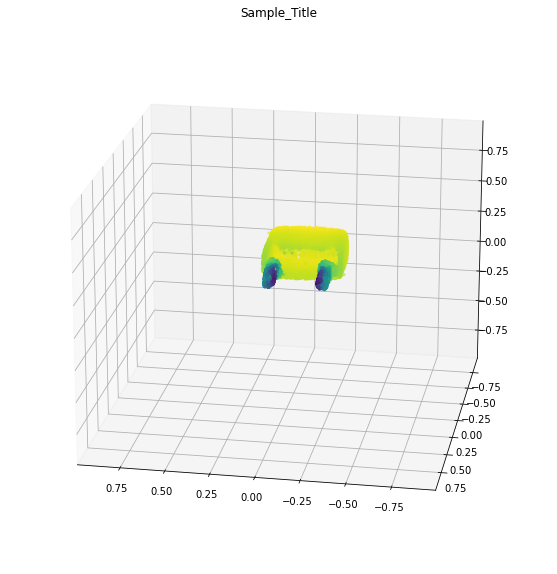

-0.00048672405

In [48]:
EPS = -1e-4
# ind_obj =  np.where((y >= -EPS) & (y <= EPS))
ind_grp = sdf_grp <= EPS

plot_sdf(queries[ind_grp], sdf_obj[ind_grp])

min(sdf_grp)

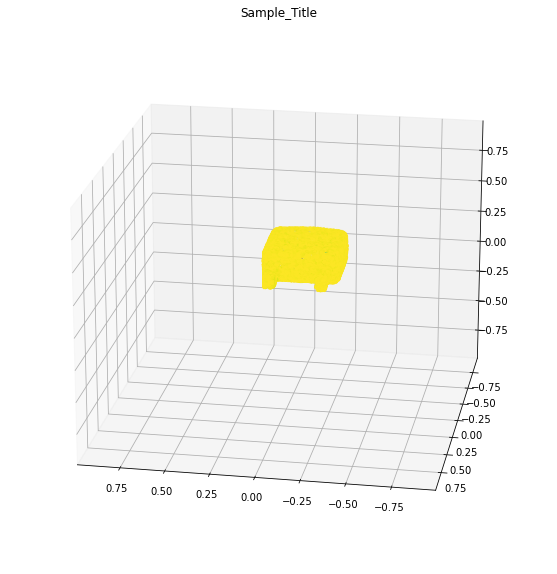

-0.12279097

In [49]:
EPS = -1e-4
# ind_obj =  np.where((y >= -EPS) & (y <= EPS))
ind_grp = gt_sdf_grp <= EPS

plot_sdf(queries[ind_grp], gt_sdf_grp[ind_grp])

min(gt_sdf_obj)

In [50]:
import pyrender
# Just pass the points you want to visualize
def plt_points_3d(pts):
    colors = np.zeros(pts.shape)
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

# Pass the point as well as the sdf to see inside/outside points
def plt_points_sdf(pts, sdf, eps=1e-4):
    colors = np.zeros(pts.shape)
    colors[sdf < eps, 1] = 1
    colors[sdf > eps, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

def plt_points_sdf_compare(pts, sdf_gt, sdf_pred):
    colors = np.zeros(pts.shape)
    colors[sdf_gt < 0, 1] = 1
    colors[sdf_gt > 0, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)
    
    colors2 = np.zeros(pts.shape)
    colors2[sdf_pred < 0, 1] = 1
    colors2[sdf_pred > 0, 0] = 1
    cloud2 = pyrender.Mesh.from_points(pts, colors=colors2)
    scene2 = pyrender.Scene()
    scene2.add(cloud2)
    viewer = pyrender.Viewer(scene2, use_raymond_lighting=True, point_size=2)

In [62]:
plt_points_3d(queries[sdf_grp < 1e-4])

In [64]:
plt_points_3d(queries[sdf_obj < -1e-4])

In [58]:
plt_points_sdf(queries, sdf_grp)

In [60]:
plt_points_sdf(queries, sdf_obj)